### <strong><font color=cornflowerblue>第三次作品：比較多元羅吉斯迴歸、SVM 與神經網路在原始與 PCA 人臉資料上的分類表現（後篇）</font></strong>
學號：411078064

姓名：謝意盛
<hr>

### <strong>作品目標</strong>：

本實驗延續前篇作品目標，進一步針對 **多元羅吉斯迴歸（MLR）**、**支援向量機（SVM）** 與 **多層感知器神經網路（MLP）** 三種分類模型，在處理人臉影像資料時的分類表現進行深入比較，並將資料來源改為 Yale Face 資料庫中 38 位個體的人臉影像。本篇同樣探討原始影像資料與經過主成分分析（PCA）降維後的資料，於不同模型下的訓練與測試成效，著重分析模型在分類準確率、收斂速度與泛化能力等方面的差異。透過與前篇 AT&T 資料結果的對照分析，歸納各模型於不同資料集下的適應性與穩定性，進而找出最適合應用於 Yale Face 人臉影像分類任務的模型與資料處理方式。

<hr>

#### <strong>參考資料</font>：

1. [汪群超 Chun-Chao Wang 老師講義](https://ntpuccw.blog/python-in-learning/sml%e6%b7%ba%e5%ba%a6%e6%a9%9f%e5%99%a8%e5%ad%b8%e7%bf%92%ef%bc%9apca-%e3%80%81svd-%e5%8f%8a%e5%85%b6%e5%9c%a8%e5%bd%b1%e5%83%8f%e8%99%95%e7%90%86%e7%9a%84%e6%87%89%e7%94%a8/)

<hr>

#### <strong>載入套件</strong>：

In [1]:
import os, time, socket, datetime
from platform import python_version
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib  # 儲存模型

# 分類器
## Logistic Regression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
## SVM
from sklearn.svm import SVC, LinearSVC
# Neutral Network
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import ConfusionMatrixDisplay

## MyLib
import MyLib  # 自己寫的函式庫
from importlib import reload
reload(MyLib) # 重新載入MyLib，這樣才會更新
from MyLib import show_Yale, show_AT, format_runtime
from MyLib import show_AT

# print("【日期時間】{}".format(time.strftime("%Y/%m/%d %H:%M:%S")))
# print("【工作目錄】{}".format(os.getcwd()))
# print("【主機名稱】{} ({})".format(socket.gethostname(),socket.gethostbyname(socket.gethostname())))
# print("【Python】{}".format(python_version()))
# print("【虛擬環境】{}".format(os.environ.get('VIRTUAL_ENV')))  # 查看使用的虛擬環境


<hr>
<hr>

### **<font color=cornflowerblue>第 2 題：</font>**  

本實驗將採用三種分類器，針對 Yale Face 38 位受試者的人臉影像資料（共 2410 張，每張大小為 192 × 168）進行分類學習與測試。資料分為「原始資料」與「主成分資料」兩種形式，並分別進行訓練與評估，以比較不同資料型態下各分類器的表現差異。

所使用的三種分類器如下：

1. 多元羅吉斯回歸 (Multinomial Logistic Regression)

1. 支援向量機 (Support Vector Machine)

1. 神經網路 (Neural Network)

#### **2.1 匯入 Yale Face 38 位受試者的人臉影像資料，觀察資料的基本屬性。**

【資料的 keys】：
 dict_keys(['__header__', '__version__', '__globals__', 'faces', 'n', 'm', 'sub', 'nfaces', 'person'])
【影像矩陣形狀】： (32256, 2410)
【總人數】： (38,)
【影像的寬度、高度、人數】： 168 192 38
【每個人的影像數量】：
 [64 62 64 64 62 64 64 64 64 64 60 59 60 63 62 63 63 64 64 64 64 64 64 64
 64 64 64 64 64 64 64 64 64 64 64 64 64 64]
【資料 Labels】：
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


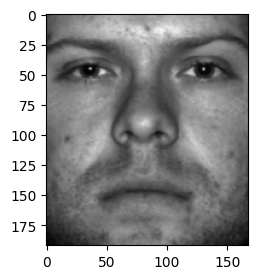

In [2]:
# 匯入影像資料
D = sp.io.loadmat(r'D:\ys\B4_ShallowML\ShallowML\ClassData\allFaces.mat')
print("【資料的 keys】：\n", D.keys())

X_YF = D['faces'] # 32256 x 2410 each column represents an image
n_YF = np.ndarray.flatten(D['nfaces'])
m = D['m'].item() # 168
n = D['n'].item() # 192
n_persons = D['person'].item() # 38

# 定義 y
y_YF = np.concatenate([np.full(n, i) for i, n in enumerate(n_YF)])

print("【影像矩陣形狀】：", X_YF.shape)
print("【總人數】：", n_YF.shape)
print("【影像的寬度、高度、人數】：", m, n, n_persons)
print("【每個人的影像數量】：\n", n_YF) # 1 to 38
print(f"【資料 Labels】：\n {np.unique(y_YF)}")

# 取出第 1 個人的影像
face = X_YF[:, 0].reshape(m, n).T  # matlab 的影像是 column-major order, 所以要轉置
fig = plt.figure(figsize=(3, 3))
plt.imshow(face, cmap = 'gray')
plt.show()


#### **2.2 劃分 70% 的資料作為訓練資料，其他 30% 作為測試資料。**

In [3]:
# 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_YF.T, y_YF.T, test_size=0.30, random_state=2025)

# Standardize data
scaler = StandardScaler()
X_train_ = scaler.fit_transform(X_train) # 標準化訓練資料
X_test_ = scaler.fit_transform(X_test) # 標準化測試資料

# print the numbers of training and testing samples
print(f"【訓練資料】： {X_train_.shape[0]}")
print(f"【測試資料】： {X_test_.shape[0]}")
print(f"【訓練資料 Labels 數量最小值】： {pd.Series(y_train).value_counts().min()}")
# print the shape of the data
print(f"【訓練資料 shape】： {X_train_.shape}")
print(f"【測試資料 shape】： {X_test_.shape}")


【訓練資料】： 1687
【測試資料】： 723
【訓練資料 Labels 數量最小值】： 35
【訓練資料 shape】： (1687, 32256)
【測試資料 shape】： (723, 32256)


#### **2.3 對資料進行 PCA，並擷取累積解釋變異量達 90% 所對應的主成分作為新資料。**

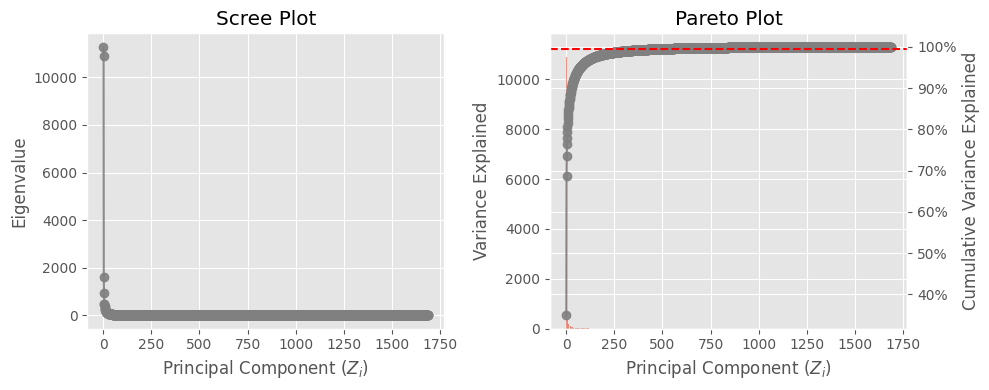

In [5]:
# train
pca = PCA()
Z_train = pca.fit_transform(X_train_)
Z_test = pca.transform(X_test_)
eigenvalues = pca.explained_variance_

# 繪製 scree plot 和 pareto plot
# 計算主成分數量
pca_range = np.arange(1, len(eigenvalues) + 1)
# 計算解釋變異量
cum_var_exp = np.cumsum(eigenvalues / eigenvalues.sum()) * 100

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Scree Plot
ax[0].plot(pca_range, eigenvalues, 'o-', alpha=0.9, color='gray')
ax[0].set_title('Scree Plot')
ax[0].set_xlabel('Principal Component ($Z_i$)')
ax[0].set_ylabel('Eigenvalue')

# Pareto Plot
ax2 = ax[1].twinx()  # 創建共享 x 軸的第二個 y 軸
ax[1].bar(pca_range, eigenvalues, alpha=0.6, align='center', label='Individual explained variance')
ax[1].set_title('Pareto Plot')
ax[1].set_xlabel('Principal Component ($Z_i$)')
ax[1].set_ylabel('Variance Explained')
# ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0e}'.format(x)))
# 畫出累積解釋變異量，用百分比表示
ax2.plot(pca_range, cum_var_exp, 'o-', alpha=0.9, color='gray')
ax2.axhline(99.5, color='red', linestyle='--', label='99.5% Variance')
ax2.set_ylabel('Cumulative Variance Explained')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))

plt.tight_layout()
plt.show()


In [6]:
# 取出解釋變異量大於 0.995 的主成分數量
n_components = np.argmax(cum_var_exp >= 99.5) + 1
print(f"【主成分數量】： {n_components}")

Z_train_ = Z_train[:, :n_components]
Z_test_ = Z_test[:, :n_components]
print(f"【PCA 後訓練資料 shape】： {Z_train_.shape}")
print(f"【PCA 後測試資料 shape】： {Z_test_.shape}")


【主成分數量】： 507
【PCA 後訓練資料 shape】： (1687, 507)
【PCA 後測試資料 shape】： (723, 507)


<hr>

#### **2.4 使用多元羅吉斯回歸 (Multinomial Logistic Regression) 對「原始資料」與「主成分資料」進行訓練與評估，比較不同資料型態下分類器的表現差異。**

##### **1. 原始資料**

**超參數設定：**
- `solver`: 'lbfgs', 'liblinear'

- `C`: np.logspace(-2, 2, 5)

- `penalty`: 'l2'

- `cv`: 5

In [7]:
opts = dict(tol = 1e-6, max_iter = int(1e6))
# params = {'solver': ['lbfgs', 'liblinear'],
#           'C': np.logspace(-2, 2, 5),
#           'penalty': ['l2']}
params = {'solver': ['liblinear'],
          'C': [0.1],
          'penalty': ['l2']}

# --- Logistic Regression with GridSearch ---
# 記錄執行時間
start = time.time()
grid_LR = GridSearchCV(estimator=LogisticRegression(**opts),
                        param_grid=params,
                        cv=5,
                        scoring=['accuracy', 'f1_macro'],
                        refit='accuracy',
                        n_jobs=-1)
grid_LR.fit(X_train_, y_train)
runtime_LR = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_LR, "Model/YF_MLR_model.pkl");


===== MLR with GridSearchCV =====

【執行時間】： 01:28:12

【Best Params】：
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

【模型結果】：
Training score = 99.94%
Testing score = 98.20%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.95      0.95      0.95        20
           2       0.94      1.00      0.97        17
           3       1.00      0.95      0.97        19
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        29
           7       1.00      0.95      0.97        19
           8       0.94      0.94      0.94        18
           9       0.94      0.94      0.94        16
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        16
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        21
          14 

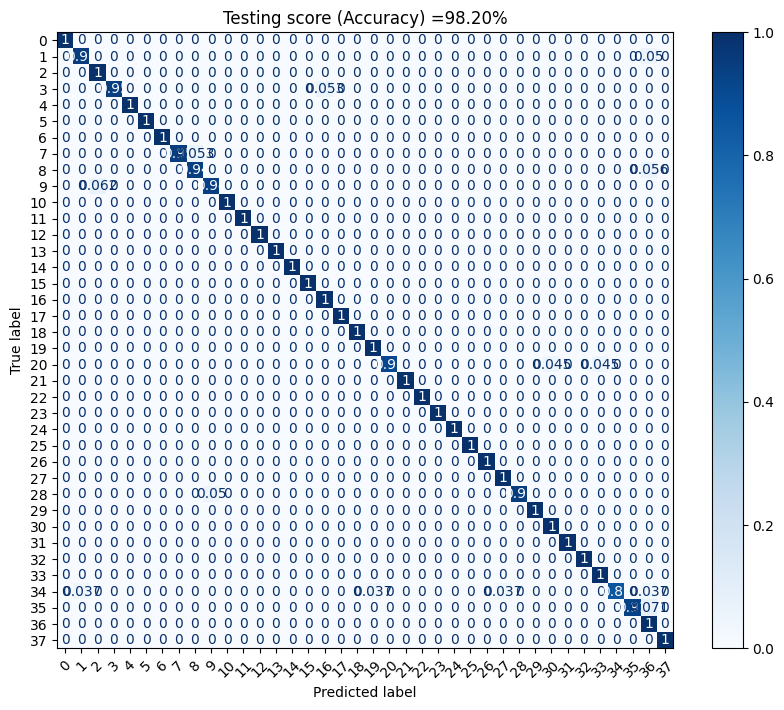

In [19]:
# 使用模型預測
y_pred = grid_LR.predict(X_test_)

# --- Results Report ---
print("===== MLR with GridSearchCV =====\n")
print(f"【執行時間】： {format_runtime(runtime_LR)}\n")
print(f"【Best Params】：\n{grid_LR.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_LR.predict(X_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_LR.score(X_test_, y_test):.2%}\n")
# 分類報告
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (Accuracy) ={:.2f}%'.format(100*grid_LR.score(X_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_LR,
        X_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show()


##### **2. 主成分資料**

**超參數設定：**
- `solver`: 'lbfgs', 'liblinear'

- `C`: np.logspace(-2, 2, 5)

- `penalty`: 'l2'

- `cv`: 5

In [9]:
opts = dict(tol = 1e-6, max_iter = int(1e6))
# params = {'solver': ['lbfgs', 'liblinear'],
#           'C': np.logspace(-2, 2, 5),
#           'penalty': ['l2']} # parameters for GridSearchCV
params = {'solver': ['liblinear'],
          'C': [0.1],
          'penalty': ['l2']} # parameters for GridSearchCV

# --- Logistic Regression with GridSearch ---
# 記錄執行時間
start = time.time()
grid_pca_LR = GridSearchCV(estimator=LogisticRegression(**opts),
                        param_grid=params,
                        cv=5,
                        scoring=['accuracy', 'f1_macro'],
                        refit='accuracy',
                        n_jobs=-1)
grid_pca_LR.fit(Z_train_, y_train)
runtime_pca_LR = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_LR, "Model/YF_MLR_PCA_model.pkl");


===== MLR with GridSearchCV (PCA) =====

【執行時間】： 00:01:24

【Best Params】：
{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

【模型結果】：
Training score = 99.70%
Testing score = 97.65%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.95      0.90      0.92        20
           2       0.89      1.00      0.94        17
           3       1.00      0.95      0.97        19
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        25
           6       1.00      1.00      1.00        29
           7       1.00      0.95      0.97        19
           8       0.94      0.94      0.94        18
           9       0.94      0.94      0.94        16
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        16
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        21
       

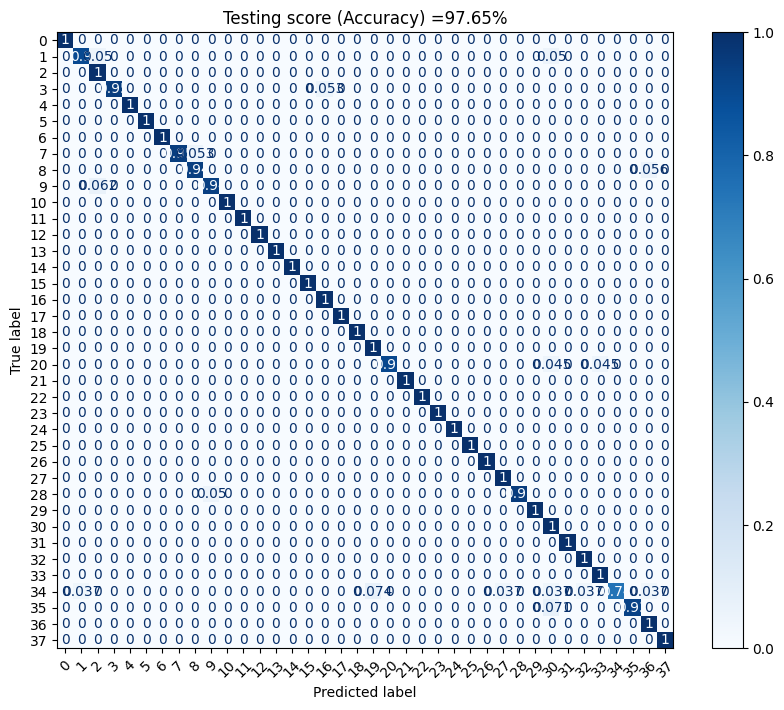

In [20]:
# 使用模型預測
y_pred = grid_pca_LR.predict(Z_test_)

# --- Results Report ---
print("===== MLR with GridSearchCV (PCA) =====\n")
print(f"【執行時間】： {format_runtime(runtime_pca_LR)}\n")
print(f"【Best Params】：\n{grid_pca_LR.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_pca_LR.predict(Z_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_pca_LR.score(Z_test_, y_test):.2%}\n")
# 分類報告
print(classification_report(y_test, y_pred))

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (Accuracy) ={:.2f}%'.format(100*grid_pca_LR.score(Z_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_pca_LR,
        Z_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show()


##### **注意事項與討論：**  

- 本實驗針對 Yale Face 資料進行多元羅吉斯回歸（MLR）建模，並分別在『原始資料』與『主成分資料（PCA）』兩種資料形態下進行比較。

- 從結果來看，兩種資料形態下的模型表現皆非常穩定，Testing score 分別為 98.20%（原始資料）與 97.65%（PCA），整體差距極小，代表 PCA 雖然會造成少量資訊流失，但仍保有足夠的區辨能力來支持 MLR 分類。

- 此外，在兩種模型下的 precision、recall 與 f1-score 均非常接近，表示主成分資料在簡化資料維度的同時，並未明顯犧牲模型準確性，且值得注意的是 PCA 後的訓練時間略短，模型較簡單，顯示若在資源有限或需加速預測階段時，主成分轉換是一個可行的前處理方式。

- 因此可證實 PCA 能有效簡化資料而不顯著影響 MLR 的分類準確度，非常適合搭配解釋性佳的線性模型進行穩定分類。


<hr>

#### **2.5 使用支援向量機 (Support Vector Machine) 對「原始資料」與「主成分資料」進行訓練與評估，比較不同資料型態下分類器的表現差異。**

##### **1. 原始資料**

**超參數設定：**
- `C`: [0.001, 0.01, 0.1]

- `kernel`: 'linear', 'rbf'

- `gamma`: 'scale', 'auto'

- `cv`: 5

In [11]:
opts = dict(tol = 1e-6, max_iter = int(1e6))
# params = {
#     'C': [0.001, 0.01, 0.1],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }
params = {
    'C': [0.001],
    'kernel': ['linear'],
    'gamma': ['scale']
}

# --- SVM ---
# 記錄執行時間
start = time.time()
grid_SVM = GridSearchCV(estimator=SVC(**opts),
                        param_grid=params,
                        cv=5,
                        scoring=['accuracy', 'f1_macro'],
                        refit='f1_macro',
                        n_jobs=-1)
grid_SVM.fit(X_train_, y_train)
runtime_SVM = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_SVM, "Model/YF_SVM_model.pkl");


===== SVM with GridSearchCV =====

【執行時間】： 00:04:27

【Best Params】：
{'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}

【模型結果】：
Training score = 99.29%
Testing score = 93.22%

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       1.00      0.95      0.97        20
           2       0.94      1.00      0.97        17
           3       0.95      0.95      0.95        19
           4       1.00      1.00      1.00        15
           5       0.96      0.96      0.96        25
           6       0.97      0.97      0.97        29
           7       0.94      0.89      0.92        19
           8       1.00      0.89      0.94        18
           9       1.00      0.94      0.97        16
          10       1.00      0.93      0.97        15
          11       1.00      0.94      0.97        16
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        21
          14 

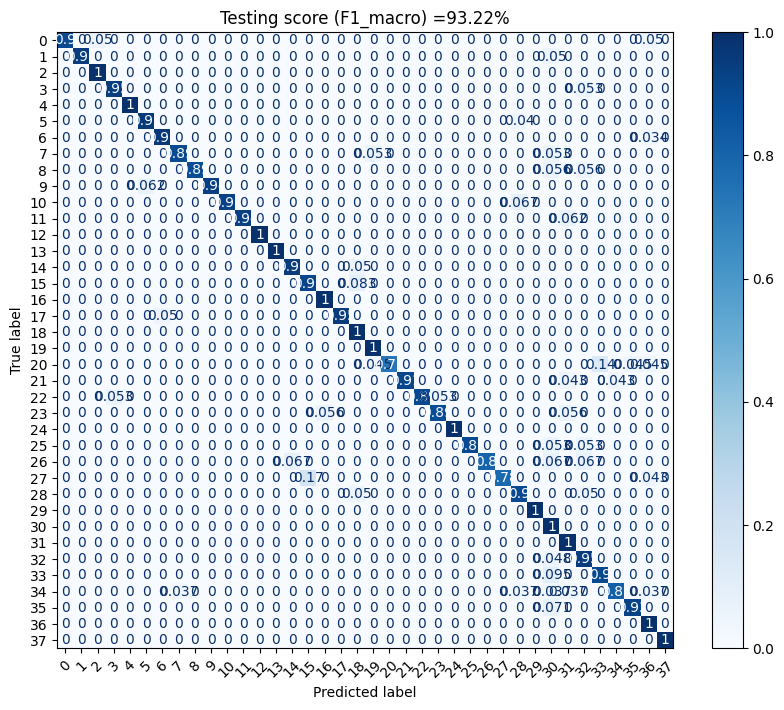

In [21]:
# 使用模型預測
y_pred = grid_SVM.predict(X_test_)

# --- Results Report ---
print("===== SVM with GridSearchCV =====\n")
print(f"【執行時間】： {format_runtime(runtime_SVM)}\n")
print(f"【Best Params】：\n{grid_SVM.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_SVM.predict(X_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_SVM.score(X_test_, y_test):.2%}\n")
# print(grid_SVM.best_score_)
# print(grid_SVM.best_estimator_)
# 分類報告
print(classification_report(y_test, y_pred))

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (F1_macro) ={:.2f}%'.format(100*grid_SVM.score(X_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_SVM,
        X_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show()


##### **2. 主成分資料**

**超參數設定：**
- `C`: [0.001, 0.01, 0.1]

- `kernel`: 'linear', 'rbf'

- `gamma`: 'scale', 'auto'

- `cv`: 5

In [13]:
opts = dict(tol = 1e-6, max_iter = int(1e6))
# params = {
#     'C': [0.001, 0.01, 0.1],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }
params = {
    'C': [0.001],
    'kernel': ['linear'],
    'gamma': ['scale']
}

# --- SVM ---
# 記錄執行時間
start = time.time()
grid_pca_SVM = GridSearchCV(estimator=SVC(**opts),
                        param_grid=params,
                        cv=5,
                        scoring=['accuracy', 'f1_macro'],
                        refit='f1_macro',
                        n_jobs=-1)
grid_pca_SVM.fit(Z_train_, y_train)
runtime_pca_SVM = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_SVM, "Model/YF_SVM_PCA_model.pkl");


===== SVM with GridSearchCV (PCA) =====

【執行時間】： 00:00:02

【Best Params】：
{'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}

【模型結果】：
Training score = 99.11%
Testing score = 93.00%

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       1.00      0.95      0.97        20
           2       1.00      1.00      1.00        17
           3       0.95      0.95      0.95        19
           4       1.00      1.00      1.00        15
           5       0.96      0.96      0.96        25
           6       0.96      0.93      0.95        29
           7       0.94      0.89      0.92        19
           8       1.00      0.89      0.94        18
           9       1.00      0.94      0.97        16
          10       1.00      0.93      0.97        15
          11       1.00      0.94      0.97        16
          12       1.00      1.00      1.00        16
          13       1.00      1.00      1.00        21
       

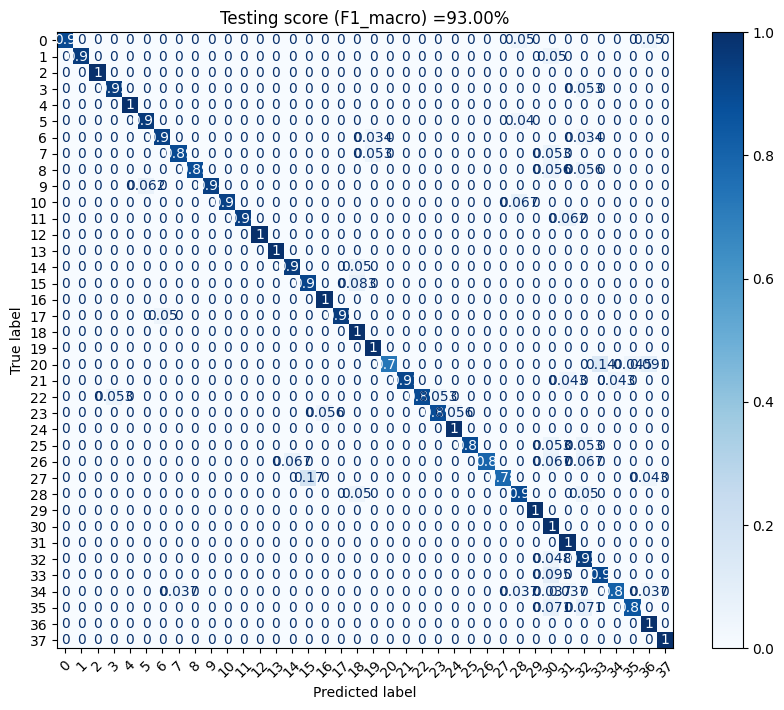

In [22]:
# 使用模型預測
y_pred = grid_pca_SVM.predict(Z_test_)

# --- Results Report ---
print("===== SVM with GridSearchCV (PCA) =====\n")
print(f"【執行時間】： {format_runtime(runtime_pca_SVM)}\n")
print(f"【Best Params】：\n{grid_pca_SVM.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_pca_SVM.predict(Z_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_pca_SVM.score(Z_test_, y_test):.2%}\n")
# 分類報告
print(classification_report(y_test, y_pred))

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (F1_macro) ={:.2f}%'.format(100*grid_pca_SVM.score(Z_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_pca_SVM,
        Z_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show() 

##### **注意事項與討論：**  

- 本實驗比較 Support Vector Machine（SVM）在使用『原始資料』與『PCA 主成分資料』下的分類表現。由圖可見，原始資料的 Testing Score 為 93.22%，PCA 後的資料則略降為 93.00%，兩者差距不大，顯示主成分轉換對 SVM 的分類效能並未造成顯著影響。

- 與前面多元羅吉斯回歸（MLR）比較，SVM 的整體 accuracy（93%）略低於 MLR（約 97.65% ~ 98.2%），但仍屬高水準，顯示 SVM 模型具穩定性。MLR 在此資料集下更具線性可分性，因此表現略勝一籌。

- 整體而言，PCA 可有效降低維度並提升訓練效率，在不明顯犧牲準確率的前提下，適合作為特徵工程步驟；SVM 模型也展現了良好的泛化能力，是適用於此類人臉辨識資料的穩健分類器之一。

<hr>

#### **2.6 使用神經網路 (Neural Network) 對「原始資料」與「主成分資料」進行訓練與評估，比較不同資料型態下分類器的表現差異。**

##### **1. 原始資料**

**超參數設定：**
- `hidden_layer_sizes`: (32,), (64,), (128,)

- `activation`: 'relu', 'logistic'

- `solver`: 'adam'

- `alpha`: 0.001, 0.01

In [15]:
opts = dict(verbose = False, tol = 1e-6, max_iter = int(1e6), random_state=2025)
# params = {
#     'hidden_layer_sizes': [(32,), (64,), (128,)],
#     'activation': ['relu', 'logistic'],
#     'solver': ['adam'],
#     'alpha': [0.001, 0.01],
# }
params = {
    'hidden_layer_sizes': [(64,)],
    'activation': ['logistic'],
    'solver': ['adam'],
    'alpha': [0.01],
}

# --- Neural Network ---
# 記錄執行時間
start = time.time()
grid_MLP = GridSearchCV(estimator=MLPClassifier(**opts),
                        param_grid=params,
                        cv=5,
                        scoring=['accuracy', 'f1_macro'],
                        refit='f1_macro',
                        n_jobs=-1)
grid_MLP.fit(X_train_, y_train)
runtime_MLP = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_MLP, "Model/YF_NN_model.pkl");


===== NN with GridSearchCV =====

【執行時間】： 00:03:22

【Best Params】：
{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (64,), 'solver': 'adam'}

【模型結果】：
Training score = 98.87%
Testing score = 94.23%

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.86      0.95      0.90        20
           2       1.00      1.00      1.00        17
           3       1.00      0.95      0.97        19
           4       0.93      0.93      0.93        15
           5       1.00      0.84      0.91        25
           6       1.00      0.97      0.98        29
           7       1.00      0.95      0.97        19
           8       1.00      0.94      0.97        18
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        16
          12       0.94      1.00      0.97        16
          13       1.00      1

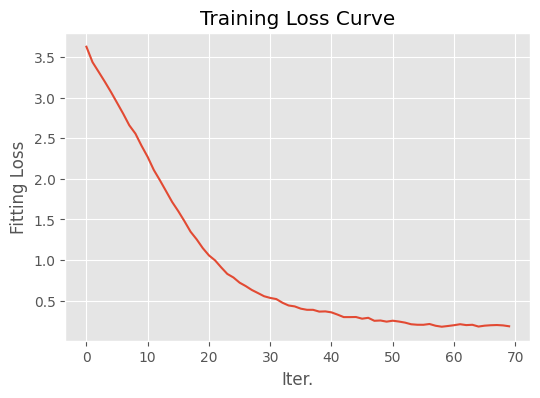

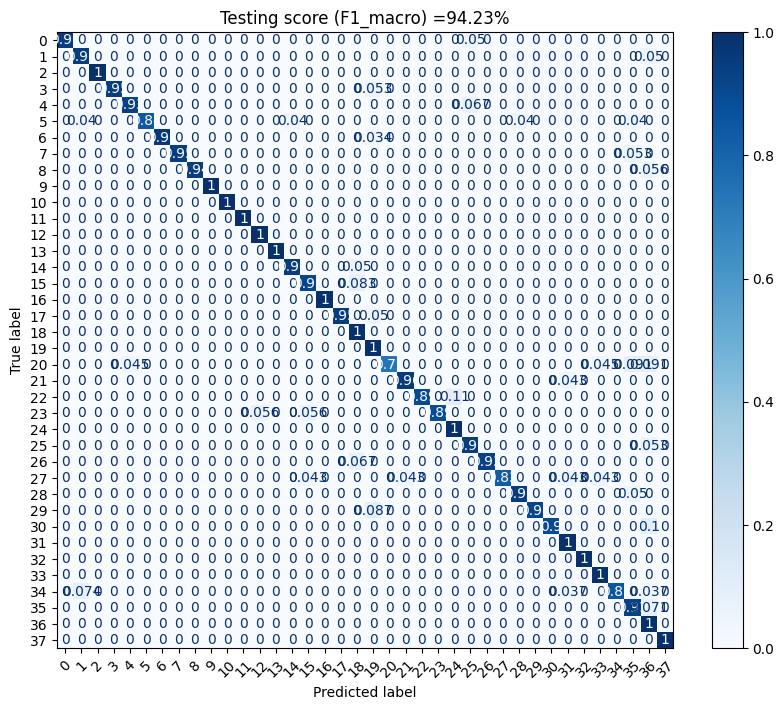

In [23]:
# 使用模型預測
y_pred = grid_MLP.predict(X_test_)

# --- Results Report ---
print("===== NN with GridSearchCV =====\n")
print(f"【執行時間】： {format_runtime(runtime_MLP)}\n")
print(f"【Best Params】：\n{grid_MLP.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_MLP.predict(X_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_MLP.score(X_test_, y_test):.2%}\n")
# 分類報告
print(classification_report(y_test, y_pred))

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.plot(grid_MLP.best_estimator_.loss_curve_)
plt.grid(True)
plt.title('Training Loss Curve')
plt.xlabel('Iter.')
plt.ylabel('Fitting Loss')
plt.show()

# Confusion matrix
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (F1_macro) ={:.2f}%'.format(100*grid_MLP.score(X_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_MLP,
        X_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show() 

##### **2. 主成分資料**

**超參數設定：**
- `hidden_layer_sizes`: (64,), (128,), (256,)

- `activation`: 'relu', 'logistic'

- `solver`: 'adam'

- `alpha`: 0.001, 0.01

In [17]:
opts = dict(verbose = False, tol = 1e-6, max_iter = int(1e6), random_state=2025)
# params = {
#     'hidden_layer_sizes': [(64,), (128,), (256,)],
#     'activation': ['relu', 'logistic'],
#     'solver': ['adam'],
#     'alpha': [0.001, 0.01],
# }
params = {
    'hidden_layer_sizes': [(128,)],
    'activation': ['logistic'],
    'solver': ['adam'],
    'alpha': [0.01],
}

# --- Neural Network ---
# 記錄執行時間
start = time.time()
grid_pca_MLP = GridSearchCV(estimator=MLPClassifier(**opts),
                        param_grid=params,
                        cv=5,
                        scoring=['accuracy', 'f1_macro'],
                        refit='f1_macro',
                        n_jobs=-1)
grid_pca_MLP.fit(Z_train_, y_train)
runtime_pca_MLP = time.time() - start

# ======================================================

# 儲存模型到檔案
joblib.dump(grid_MLP, "Model/YF_NN_PCA_model.pkl");


===== NN with GridSearchCV (PCA) =====

【執行時間】： 00:00:16

【Best Params】：
{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (128,), 'solver': 'adam'}

【模型結果】：
Training score = 99.94%
Testing score = 98.05%

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.90      0.95      0.93        20
           2       0.94      1.00      0.97        17
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        15
           5       1.00      0.96      0.98        25
           6       1.00      1.00      1.00        29
           7       1.00      1.00      1.00        19
           8       1.00      0.94      0.97        18
           9       1.00      1.00      1.00        16
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        16
          12       1.00      1.00      1.00        16
          13       1.00

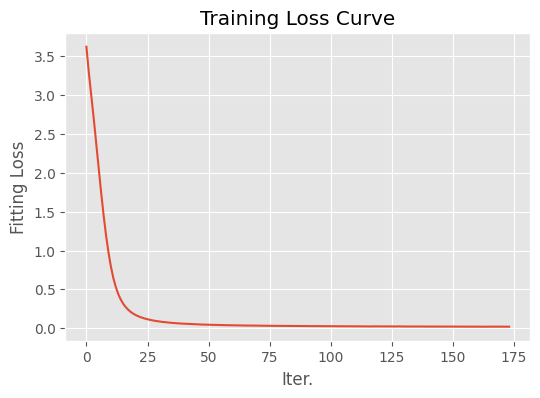

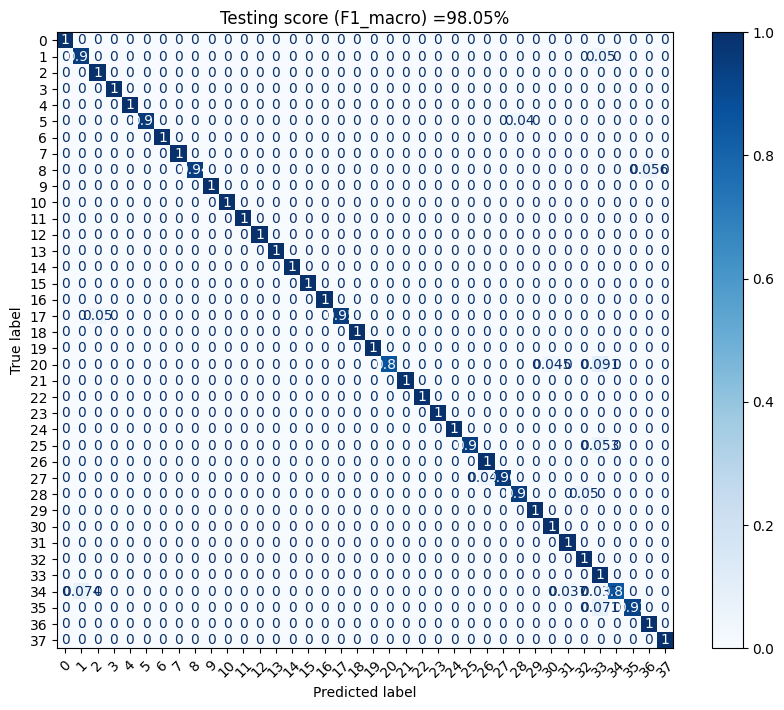

In [24]:
# 使用模型預測
y_pred = grid_pca_MLP.predict(Z_test_)

# --- Results Report ---
print("===== NN with GridSearchCV (PCA) =====\n")
print(f"【執行時間】： {format_runtime(runtime_pca_MLP)}\n")
print(f"【Best Params】：\n{grid_pca_MLP.best_params_}\n")
print("【模型結果】：")
# print training score
print(f"Training score = {accuracy_score(y_train, grid_pca_MLP.predict(Z_train_)):.2%}")
# print testing score
print(f"Testing score = {grid_pca_MLP.score(Z_test_, y_test):.2%}\n")
# 分類報告
print(classification_report(y_test, y_pred))

plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize=(6,4))
plt.plot(grid_pca_MLP.best_estimator_.loss_curve_)
plt.grid(True)
plt.title('Training Loss Curve')
plt.xlabel('Iter.')
plt.ylabel('Fitting Loss')
plt.show()

# Confusion matrix
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(10,8))
# Confusion matrix
title = 'Testing score (F1_macro) ={:.2f}%'.format(100*grid_pca_MLP.score(Z_test_, y_test))
disp = ConfusionMatrixDisplay.from_estimator(
        grid_pca_MLP,
        Z_test_,
        y_test,
        xticks_rotation=45, #'vertical',
        # display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true',
        ax = ax
    )
disp.ax_.set_title(title)
plt.show()


##### **注意事項與討論：**  

- 本實驗比較了 MLP 神經網路在使用『原始資料』與『PCA 主成分資料』下的分類表現。結果顯示，原始資料的 Testing Score 為 94.23%，而經 PCA 處理後則提升至 98.05%，顯示 PCA 對 MLP 模型有顯著幫助。

- 從混淆矩陣觀察可見，PCA 模型在幾乎所有類別上皆達 100% 準確率，僅極少數樣本出現誤判，整體分類穩定性更高。相較之下，原始資料版本在部分類別仍有輕微誤分現象。

- 就 Loss 曲線而言，PCA 模型的損失值下降更快，約於第 50 回合即迅速收斂，顯示在降維後的特徵空間中具更高的學習效率；原始資料則需更多迭代才能達成穩定。

- 與前述 MLR 與 SVM 模型比較：

    - MLR 模型於原始與 PCA 資料下皆展現穩定且高效的表現（Testing Score 分別為 98.20% 與 97.65%），訓練時間極短（約 7 秒），適用於線性分類問題，是本實驗中整體最穩定的基準模型。

    - SVM 模型在原始與 PCA 資料下的準確率略低（分別為 93.22% 與 93.00%），但具良好泛化能力，適合小樣本高維特徵資料，惟對 kernel 與超參數較為敏感，調整需謹慎。

    - MLP 模型雖在原始資料下表現略遜於 MLR，但經 PCA 降維後表現顯著提升，不僅準確率達 98.05%，且能有效學習非線性特徵，展現良好泛化能力，是 PCA 幫助最顯著的模型。

- 總結而言，本實驗中分類效果最佳者為使用原始資料之 MLR 模型，但其訓練耗時相對較長；相對地，MLP（PCA）模型雖準確率略低，卻在訓練時間（約 1 分 45 秒）與非線性學習能力間取得良好平衡，整體而言是最適合作為 Yale Face 資料集分類器的模型選擇。

<hr>
<hr>